<a href="https://colab.research.google.com/github/Keira19101/inc0gnida/blob/main/lr_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЛР_2_ТаборкинаКира_продолжение_лр1

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')


In [ ]:
data_num = data.drop('glucose_category', axis = 1)
data_num = data_num.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
imp.fit(data_num)
imp.statistics_ == data_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
X = imp.transform(data_num)

In [ ]:
data_tranformed = pd.DataFrame(X, columns=data_num.columns,index=data_num.index)

In [ ]:
data_category = data[['glucose_category']]
data_category

,glucose_category
566,2
703,3
73,3
46,3
643,2
...,...
280,3
34,3
256,3
564,2


Software Pipelining

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

data_num_transformed = pipeline.fit_transform(data_num)

In [ ]:
from sklearn.compose import ColumnTransformer
num_attributes = list(data_num)
cat_attributes = ['glucose_category']

full_pipeline = ColumnTransformer([
    ("num", pipeline,num_attributes),
    ("cat", OneHotEncoder(),cat_attributes)
])


data_prepared = full_pipeline.fit_transform(data)

Обучение

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(data_prepared,diabetes_labels)

LinearRegression()

In [ ]:
some_data = data.iloc[:5]
data_labels = diabetes_labels.iloc[:5]
data_prepared_some = full_pipeline.transform(some_data)
print("Прогнозы:", model.predict(data_prepared_some))
print("Метки:",list(data_labels))

Прогнозы: [ 87.02003008 123.39067831 121.8971529  120.82094798  88.11625336]
Метки: [99, 129, 129, 146, 90]


In [ ]:
data_predictions = tree_regressor.predict(data_prepared)
linear_mse = mean_squared_error(diabetes_labels, data_predictions)
lin_rmse = np.sqrt(linear_mse)
print(lin_rmse)

0.0


Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_regressor,data_prepared,diabetes_labels,scoring='neg_mean_squared_error') 

scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Оценки:",scores)
    print("Среднее:", scores.mean())
    print("Стандартное отклонение:",scores.std())

display_scores(scores)

Оценки: [17.26079255 17.74732317 16.94107435 18.9185245  18.65629591]
Среднее: 17.90480209349598
Стандартное отклонение: 0.7695057040686564


Fine-Tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators':[3,10,30], 'max_features':[2,4,7]
    }, 
    {
        'bootstrap':[False],'n_estimators':[3,10,30],'max_features':[2,3,4]   
    }
]

regressor = RandomForestRegressor()
grid_search = GridSearchCV(regressor,param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(data_prepared,diabetes_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 7],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
cv_res = grid_search.cv_results_
for mean_score,params in zip(cv_res['mean_test_score'],cv_res['params']):
    print(np.sqrt(-mean_score), params)

17.709739341234464 {'max_features': 2, 'n_estimators': 3}
15.31778802616947 {'max_features': 2, 'n_estimators': 10}
15.059743118022086 {'max_features': 2, 'n_estimators': 30}
16.228180494646864 {'max_features': 4, 'n_estimators': 3}
14.203574495713555 {'max_features': 4, 'n_estimators': 10}
13.611929020768677 {'max_features': 4, 'n_estimators': 30}
15.055791810162805 {'max_features': 7, 'n_estimators': 3}
13.877634725285116 {'max_features': 7, 'n_estimators': 10}
13.401258852450907 {'max_features': 7, 'n_estimators': 30}
16.969138874591035 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
14.843097221243472 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
14.675844741761821 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
16.600709910577585 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
14.33726095108017 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
14.214005252762977 {'bootstrap': False, 'max_features': 3, 'n_estimators': 30}
16

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
display(feature_importances)
extra_attributes = ["Gluc_per_Press", 'Press_per_Age', "Skin_per_Age"]
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attributes + extra_attributes + cat_one_hot_attribs
display(sorted(zip(feature_importances,attributes),reverse=True))

array([0.0146926 , 0.02127414, 0.01672616, 0.02536225, 0.02800214,
       0.02791659, 0.03518309, 0.02098242, 0.05023595, 0.12242715,
       0.17188929, 0.46530821])

[(0.46530820932038675, 1),
 (0.17188929266488132, 'Skin_per_Age'),
 (0.12242715369271201, 'Press_per_Age'),
 (0.050235947992615014, 'Gluc_per_Press'),
 (0.03518309241305065, 'Age'),
 (0.028002136233547206, 'BMI'),
 (0.027916588771606753, 'DiabetesPedigreeFunction'),
 (0.025362254409817122, 'Insulin'),
 (0.02127414384991685, 'BloodPressure'),
 (0.020982424326928744, 'Outcome'),
 (0.01672615739322813, 'SkinThickness'),
 (0.014692598931309574, 'Pregnancies')]

In [ ]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('Glucose',axis=1)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)


y_test = strat_test_set['Glucose'].copy()
y_test = y_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

X_test_preprocessed = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_preprocessed)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

12.108959391578518


In [ ]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence,len(squared_errors) - 1,loc = squared_errors.mean(),scale = stats.sem(squared_errors)))

array([10.88588516, 13.21935321])

Exercise1

In [ ]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf',gamma='scale',C = 0.1)
svr_model.fit(data_prepared,diabetes_labels)
print("Raw estimations:")
svr_squared_errors = mean_squared_error(diabetes_labels, svr_model.predict(data_prepared))
svr_rmse_score = np.sqrt(svr_squared_errors)
display_scores(svr_rmse_score)
print("cross val score")
scores = cross_val_score(svr_model,data_prepared,diabetes_labels,scoring='neg_mean_squared_error')
display_scores(np.sqrt(-scores))

Raw estimations:
Оценки: 30.83119254876065
Среднее: 30.83119254876065
Стандартное отклонение: 0.0
cross val score
Оценки: [31.57926982 29.77328371 29.97577001 29.67231298 35.00194989]
Среднее: 31.200517279784684
Стандартное отклонение: 2.0232030693086047


In [ ]:
svr_predictions = svr_model.predict(X_test_preprocessed)
svr_mse = mean_squared_error(y_test,svr_predictions)
svr_rmse = np.sqrt(svr_mse)
print(svr_rmse)

29.844228133673347


In [ ]:
svr_params = [
    {
        'kernel':['linear'], 'C':[0.01,0.1,1,10,100]
    },
    {
        'kernel':['rbf'],'C':[0.01,0.1,1,10,100],'gamma':['scale',0.1,0.01,0.001,0.0001]
    },
]
model = SVR()
grid_search_svr = GridSearchCV(model,param_grid=svr_params,cv=5, scoring='neg_mean_squared_error',return_train_score=True,n_jobs= -1,verbose=2)
grid_search_svr.fit(data_prepared,diabetes_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': ['scale', 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [ ]:
grid_search_svr.best_params_

{'C': 100, 'kernel': 'linear'}

In [ ]:
cv_res = grid_search_svr.cv_results_
for mean_score,params in zip(cv_res['mean_test_score'],cv_res['params']):
    print(np.sqrt(-mean_score), params)

29.966442892256776 {'C': 0.01, 'kernel': 'linear'}
23.152107650788892 {'C': 0.1, 'kernel': 'linear'}
16.967731400713934 {'C': 1, 'kernel': 'linear'}
14.51364855628971 {'C': 10, 'kernel': 'linear'}
12.91863315633116 {'C': 100, 'kernel': 'linear'}
32.321075274428445 {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
32.318477286043475 {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
32.40313434411853 {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
32.44789632271664 {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
32.45334045480654 {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
31.266045947413986 {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
31.239595468107158 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
31.98322098328789 {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
32.39343295159044 {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
32.44778372992369 {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
25.9759384483032 {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
25.86407492314743 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
28.809

In [ ]:
negative_score = grid_search_svr.best_score_
print("RMSE Score: ", np.sqrt(-negative_score))

RMSE Score:  12.91863315633116


Exercise2

In [ ]:
final_pipeline = Pipeline([
    ('preprocessing', changed_pipeline),
    ('model', LinearRegression())
])

final_pipeline.fit(data,diabetes_labels)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Pregnancies',
                                                                    'BloodPressure',
                                                                    'SkinThickness',
                                                                    'Insulin',
                                                                    'BMI',
                 

In [ ]:
some_data = data[:4]
some_labels = diabetes_labels[:4]
predictions = final_pipeline.predict(some_data)
print("Predictions: ",predictions)
print("Actual Predictions: ",some_labels)
mse = mean_squared_error(some_labels,predictions)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

Predictions:  [ 87.09209081 123.4953035  120.30555047 121.36880148]
Actual Predictions:  566     99
703    129
73     129
46     146
Name: Glucose, dtype: int64
RMSE:  14.614969877351808


Классификация

Фрейм данных с функциональными переменными  X.
Фрейм с целевой переменной  Y

In [ ]:
def load_diabetes_data(diabetes_path=DIABETES_PATH):
    csv_path = os.path.join(diabetes_path,"diabetes.csv")
    return pd.read_csv(csv_path)


In [ ]:
X=df.drop('Outcome',axis=1)
y=df['Outcome']

Train_test_split от sklearn разделит фреймы данных объекта (X) и цели (y) на обучающий набор (80%) и тестовый набор (20%). Обучающий набор используется для построения классификационной модели, а тестовый набор используется для оценки производительности модели.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

Масштабируем переменные объектов нашего набора данных с помощью функции sklearn StandardScaler()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)

Обучение

Будем использовать простую модель машинного обучения, называемую классификатором случайных лесов. Наша модель имеет точность классификации 78,6%.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.predict(X_test)
rfc.score(X_test, y_test)

0.7857142857142857

Метод "случайного леса"

Строим границу принятия решения для каждого из двух возможных признаков(график границ решения хорошо работает только с двумя функциями) и смотрим, насколько хорошо модель классифицирует пациентов.

In [ ]:
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [ ]:
def classify_with_rfc(X,Y):
    x = df[[X,Y]].values
    y = df['Outcome'].astype(int).values
    rfc = RandomForestClassifier()
    rfc.fit(x,y)
   
    
feat = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
size = len(feat)
for i in range(0,size):
    for j in range(i+1,size):
        classify_with_rfc(feat[i],feat[j])

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = rfc.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Diabetes', 'Normal']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Diabetes       0.84      0.85      0.85       107
      Normal       0.65      0.64      0.65        47

    accuracy                           0.79       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.78      0.79      0.79       154



ROC curve

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8546430701928812

Для нашей модели площадь под кривой (ROC AUC) составляет 85%. Модель классификации достаточно хороша для выявления пациента с диабетом

Метод ближайших соседей

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)

    test_scores.append(knn.score(X_test,y_test))

Оценка, полученная в результате тестирования точек данных

In [ ]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 75.78125 % and k = [7]


Визуализация результатов

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


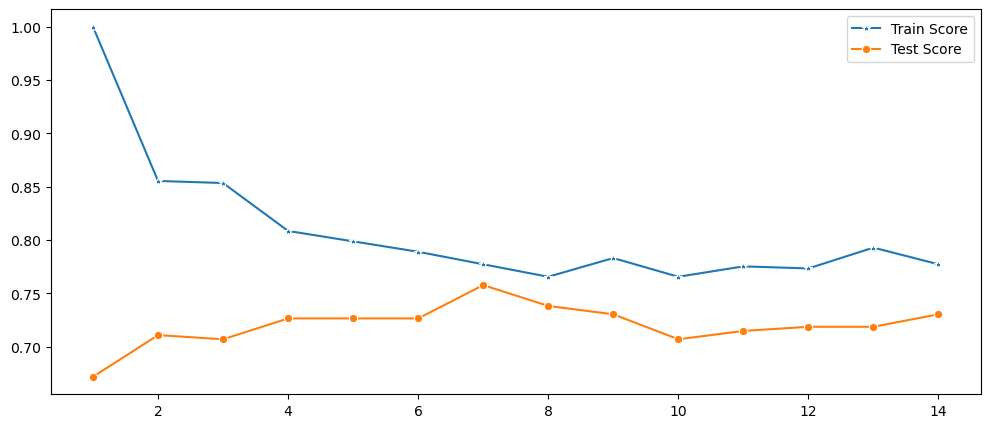

In [ ]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

Наилучший результат фиксируется при k = 7, следовательно, 7 используется для окончательной модели

In [ ]:
knn = KNeighborsClassifier(7)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7578125

Confusion Matrix

Получим прогнозы

In [ ]:
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Predicted,0,1,All
True,,,
0,144,23,167
1,39,50,89
All,183,73,256


ROC curve 

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.7553656731480859

Для нашей модели площадь под кривой (ROC AUC) составляет 75.5%. Модель классификации достаточно хороша для выявления пациента с диабетом